In [1]:
print("Hello LangGraph!")

Hello LangGraph!


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

## Basic LangGraph
- Node
- Edge
- starting point and ending point
- Visualization of graph and stream of output

In [3]:
def f1(input):
    return "Function f1 : "+input

def f2(input):
    return "Function f2 : "+input

In [4]:
from langgraph.graph import Graph

In [5]:
workflow = Graph()

workflow.add_node("f1", f1)
workflow.add_node("f2", f2)
workflow.add_edge("f1", "f2")
workflow.set_entry_point("f1")
workflow.set_finish_point("f2")


In [6]:
app = workflow.compile()

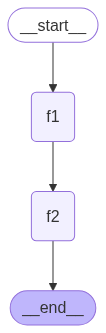

In [7]:
from IPython.display import display, Image

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [8]:
app.invoke("Hello World")

'Function f2 : Function f1 : Hello World'

In [9]:
input="Hello World"
for output in app.stream(input):
    for k,v in output.items():
        print(f"Output from key {k}")
        print("----")
        print(v)
        print("\n")
    

Output from key f1
----
Function f1 : Hello World


Output from key f2
----
Function f2 : Function f1 : Hello World




In [10]:
def f1(input):
    return "Function f1 : "+input

def upper_string(input):
    return input.upper()

workflow_1 = Graph()
workflow_1.add_node("f1", f1)
workflow_1.add_node("upper_string", upper_string)
workflow_1.add_edge("f1", "upper_string")
workflow_1.set_entry_point("f1")
workflow_1.set_finish_point("upper_string")
app_1 = workflow_1.compile()
app_1.invoke("Hello World")

'FUNCTION F1 : HELLO WORLD'

## Basic RAG Example

### Basic setup
- GoogleGenerativeAIEmbeddings
- ChatGoogleGenerativeAI --> gemini-1.5-flash
- ChromaDB

In [11]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings,ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [12]:

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

vectors = embeddings.embed_documents(
    [
        "Today is Monday",
        "Today is Tuesday",
        "Today is April Fools day",
    ]
)
len(vectors), len(vectors[0])

(3, 768)

In [13]:
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)


In [14]:
llm.invoke([
    SystemMessage("For any given country you will return their prime minister name"),
    HumanMessage("India")
    ])

AIMessage(content='The current Prime Minister of India is Narendra Modi.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--5b82c9ad-02d7-409d-b06e-0a9bc6ee983a-0', usage_metadata={'input_tokens': 12, 'output_tokens': 11, 'total_tokens': 23, 'input_token_details': {'cache_read': 0}})

In [15]:
docs = DirectoryLoader(".", glob="*.txt", show_progress=True).load() # loads all text files in the current directory

100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


In [16]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)

new_docs = text_splitter.split_documents(docs)

In [17]:
new_docs

[Document(metadata={'source': 'langgraph_sample_kb.txt'}, page_content='LangGraph is an open-source Python library developed by LangChain Inc. It enables the construction of stateful, multi-agent workflows for large language model (LLM) applications. Unlike traditional Directed Acyclic Graph (DAG) frameworks, LangGraph supports cycles and loops, making it ideal for complex, interactive agent behaviors.([geeksrepos.com][1], [Real Python][2], [Medium][3])\n\n---\n\n### 🔧 Key Features of LangGraph\n\n**Graph\n\nBased Architecture\n\n**: Define workflows as graphs with nodes (agents or functions) and edges (transitions), allowing for intricate control flows, including cycles and branching.\n\n**Stateful Execution\n\n**: Maintain and persist state across interactions, enabling long\n\nterm memory and context retention.\n\n**Human\n\nin\n\nthe\n\nLoop\n\n**: Incorporate human oversight by pausing execution for approvals or interventions, enhancing reliability.([geeksrepos.com][1])\n\n**Strea

In [18]:
db = Chroma.from_documents(new_docs, embeddings, persist_directory="chroma_db")
retriever = db.as_retriever(search_kwargs={"k": 2})

In [19]:
query = "What is langgraph?"

results = retriever.get_relevant_documents(query)

print(results[0].metadata)
print(results[0].page_content)

/var/folders/86/brsg9wgd0wbbdymjwnpjnv_h0000gn/T/ipykernel_16798/3343993480.py:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  results = retriever.get_relevant_documents(query)


{'source': 'langgraph_sample_kb.txt'}
LangGraph is an open-source Python library developed by LangChain Inc. It enables the construction of stateful, multi-agent workflows for large language model (LLM) applications. Unlike traditional Directed Acyclic Graph (DAG) frameworks, LangGraph supports cycles and loops, making it ideal for complex, interactive agent behaviors.([geeksrepos.com][1], [Real Python][2], [Medium][3])

---

### 🔧 Key Features of LangGraph

**Graph

Based Architecture

**: Define workflows as graphs with nodes (agents or functions) and edges (transitions), allowing for intricate control flows, including cycles and branching.

**Stateful Execution

**: Maintain and persist state across interactions, enabling long

term memory and context retention.

**Human

in

the

Loop

**: Incorporate human oversight by pausing execution for approvals or interventions, enhancing reliability.([geeksrepos.com][1])

**Streaming Support

**: Stream outputs token

by

token, providing r

### Use it in Langgraph

In [20]:
def f1(AgentState):
    message = AgentState["message"]
    question = message[-1]
    prompt = f"Your task is to give brief answer to the question: {question}"
    response = llm.invoke(prompt)
    AgentState["message"].append(response.content)
    return AgentState

def f2(AgentState):
    question = AgentState["message"][0] # User question

    prompt_template = """Answer the question based on following context: 
    {context}
    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(prompt_template)

    retrival_chain = (
        {"context":retriever, "question":RunnablePassthrough()}
        | prompt
        | llm 
        | StrOutputParser()
        )
    
    retuslt = retrival_chain.invoke(question)
    return retuslt

In [21]:
workflow_basic_rag = Graph()
workflow_basic_rag.add_node("llm", f1)
workflow_basic_rag.add_node("retriever", f2)
workflow_basic_rag.add_edge("llm", "retriever")
workflow_basic_rag.set_entry_point("llm")
workflow_basic_rag.set_finish_point("retriever")

app_basic_rag = workflow_basic_rag.compile()

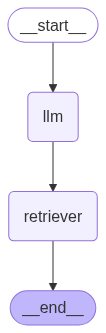

In [22]:
from IPython.display import display, Image
try:
    display(Image(app_basic_rag.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [23]:
input = {"message": ["What is LangGraph?"]}
app_basic_rag.invoke(input)

"LangGraph is an open-source Python library developed by LangChain Inc.  It's used to build stateful, multi-agent workflows for large language model (LLM) applications.  Unlike traditional DAG frameworks, it supports cycles and loops, making it suitable for complex, interactive agent behaviors."

In [24]:
input = {
    "message": ["What is LangGraph?"]
}
for output in app_basic_rag.stream(input):
    for k,v in output.items():
        print(f"Output from key {k}")
        print("----")
        print(v)
        print("\n")

Output from key llm
----
{'message': ['What is LangGraph?', 'LangGraph is a knowledge graph representing the relationships between programming languages.']}


Output from key retriever
----
LangGraph is an open-source Python library developed by LangChain Inc.  It's used to build stateful, multi-agent workflows for large language model (LLM) applications.  Unlike traditional DAG frameworks, it supports cycles and loops, making it suitable for complex, interactive agent behaviors.




### Flow where it will take a call which one to use : RAG or directly LLM

In [25]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser

from pydantic import BaseModel, Field

In [26]:
class AgentState(TypedDict):
    message: Annotated[Sequence[BaseMessage], operator.add]


class TopicSelectionParser(BaseModel):
    Topic: str = Field(description="Selected topic")
    Reason: str = Field(description="Reason behind the topic selection")

In [27]:
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [28]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "Selected topic", "title": "Topic", "type": "string"}, "Reason": {"description": "Reason behind the topic selection", "title": "Reason", "type": "string"}}, "required": ["Topic", "Reason"]}\n```'

In [29]:
def f1(state):
    message = state["message"]
    question = message[-1]
    
    template = """Classify given query into one of the given category : [LangGraph, Not Related]. 
    Only return the selected category.
    User query: {question}

    {format_instructions}
    """
    prompt = PromptTemplate.from_template(template,
                                          partial_variables={"format_instructions": parser.get_format_instructions()}
                                          )
    
    #  prompt = ChatPromptTemplate.from_template(prompt_template)

    # retrival_chain = (
    #     {"context":retriever, "question":RunnablePassthrough()}
    #     | prompt
    #     | llm 
    #     | StrOutputParser()
    #     )
    
    # retuslt = retrival_chain.invoke(question)
    chain = prompt | llm | parser
    response = chain.invoke({"question": question})
    print(response)
    state["message"].append(response.Topic)
    print("inside f1 after update: ",state)
    return state

In [30]:
def route(state):
    message = state["message"]
    topic = message[-1]    
    if "langgraph" == topic.lower():
        return "retriever_flow"
    else:
        return "llm_flow"

In [31]:
def f2(state):
    print("RAG function--->")
    print(state)
    question = state["message"][0] # User question
    template = """Answer the question based on following context:
    {context}
    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    retrieval_chain = (
        {"context":retriever, "question":RunnablePassthrough()}
        | prompt
        | llm 
        | StrOutputParser()
    )
    result = retrieval_chain.invoke(question)
    return {"message":[result]}

In [32]:
def f3(state):
    print("LLM function--->")
    question = state["message"][0] # User question
    
    prompt = f"Your task is to give brief answer to the question: {question}"
    response = llm.invoke(prompt)
    return {"message":[response.content]}
    

In [33]:
AgentState

__main__.AgentState

In [34]:
from langgraph.graph import StateGraph, END, START

workflow_basic_rag_decision = StateGraph(AgentState)

workflow_basic_rag_decision.add_edge(START, "Agent")
workflow_basic_rag_decision.add_node("Agent", f1)
workflow_basic_rag_decision.add_node("retriever", f2)
workflow_basic_rag_decision.add_node("llm", f3)


workflow_basic_rag_decision.add_conditional_edges(
    "Agent",
    route,
    {
        "retriever_flow": "retriever",
        "llm_flow": "llm"
    })
workflow_basic_rag_decision.add_edge("retriever", END)
workflow_basic_rag_decision.add_edge("llm",END)

app_basic_rag_decision = workflow_basic_rag_decision.compile()

In [40]:
from IPython.display import display, Image
try:
    display(Image(app_basic_rag_decision.get_graph().print_ascii()))
except Exception as e:
    print(e)

      +-----------+         
      | __start__ |         
      +-----------+         
            *               
            *               
            *               
        +-------+           
        | Agent |           
        +-------+           
        .       .           
      ..         ..         
     .             .        
+-----+       +-----------+ 
| llm |       | retriever | 
+-----+*      +-----------+ 
        *       *           
         **   **            
           * *              
      +---------+           
      | __end__ |           
      +---------+           
No image data found. Expecting filename, url, or data.


In [36]:
input = {
    "message": ["What is LangGraph?"]
}
app_basic_rag_decision.invoke(input)

Topic='LangGraph' Reason='The query directly asks for the definition of LangGraph.'
inside f1 after update:  {'message': ['What is LangGraph?', 'LangGraph']}
RAG function--->
{'message': ['What is LangGraph?', 'LangGraph', 'What is LangGraph?', 'LangGraph']}


{'message': ['What is LangGraph?',
  'LangGraph',
  'What is LangGraph?',
  'LangGraph',
  "LangGraph is an open-source Python library developed by LangChain Inc.  It's used to build stateful, multi-agent workflows for large language model (LLM) applications.  Unlike traditional DAG frameworks, it supports cycles and loops, making it suitable for complex, interactive agent behaviors."]}

In [37]:
input = {
    "message": ["What is LlamaIndex?"]
}
app_basic_rag_decision.invoke(input)

Topic='Not Related' Reason='LlamaIndex is not related to LangGraph.'
inside f1 after update:  {'message': ['What is LlamaIndex?', 'Not Related']}
LLM function--->


{'message': ['What is LlamaIndex?',
  'Not Related',
  'What is LlamaIndex?',
  'Not Related',
  'LlamaIndex is an open-source framework for building LLM applications on your own data.']}

In [38]:
for output in app_basic_rag_decision.stream(input):
    for k,v in output.items():
        print(f"Output from key {k}")
        print("----")
        print(v)
        print("\n")

Topic='Not Related' Reason='LlamaIndex is a framework for building LLM applications, not directly related to LangGraph.'
inside f1 after update:  {'message': ['What is LlamaIndex?', 'Not Related']}
Output from key Agent
----
{'message': ['What is LlamaIndex?', 'Not Related']}


LLM function--->
Output from key llm
----
{'message': ['LlamaIndex is an open-source framework for building LLM applications on your own data.']}


